# 说明
此笔记本为记录笔记本，主要学习了 DNN 网络的搭建，并附带上了我自己写的一些注释，代码的整个流程参考如下视频：
- PyTorch深度学习：深度神经网络（DNN）：[https://www.bilibili.com/video/BV1Z8411R7PH](https://www.bilibili.com/video/BV1Z8411R7PH)
- 一小时从函数到Transformer！一路大白话彻底理解AI原理（推荐观看至P2）：[https://www.bilibili.com/video/BV1NCgVzoEG9](https://www.bilibili.com/video/BV1NCgVzoEG9)

前置库安装：
- pip install torch  # GPU-cuda 版本去 pytorch 官网下载
- pip install matplotlib


# Pytorch 前期准备

In [1]:
import torch

In [2]:
# 创建一个张量，该张量默认在 CPU 上，二维张量类似于矩阵，但是张量可以是三维或是更大维度的，可以理解为是矩阵的堆叠。
# torch.randn 用于生成 **标准正态分布** 的随机数，即均值为 0 ，标准差为 1 的数据
# 相较于 rand ，rand 就是纯生成随机数
ts1 = torch.rand(3, 4)
print(ts1, ts1.device)

tensor([[0.1767, 0.9093, 0.5415, 0.0849],
        [0.7790, 0.7943, 0.1905, 0.2748],
        [0.1111, 0.7403, 0.5302, 0.8431]]) cpu


In [3]:
ts2 = ts1.to('cuda')
print(ts2)  # 在 Pycharm 中直接 ts2 的话会出现 can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first. 因为默认他是要讲类 numpy 对象变为表格，但是 ts2 已经被转移到 GPU 上了，要看的话得先 ts2.cpu()

tensor([[0.1767, 0.9093, 0.5415, 0.0849],
        [0.7790, 0.7943, 0.1905, 0.2748],
        [0.1111, 0.7403, 0.5302, 0.8431]], device='cuda:0')


In [4]:
import torch
import torch.nn as nn  # nn 是 Neural network （神经网络）的意思
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
# 设置 matplotlib 绘图库绘制高清图
from matplotlib_inline import backend_inline
backend_inline.set_matplotlib_formats('svg')

# DNN 的实现

In [6]:
# 准备训练集 X1 X2 X3 是模拟三个输入特征，下面都将生成一个 1000 * 1 的张量
X1 = torch.rand(20000, 1)
X2 = torch.rand(20000, 1)
X3 = torch.rand(20000, 1)

# 准备输出特征，这个过程叫 One-Hot 编码（独热编码） 过程，独热编码 （One-Hot Encoding）是一种将分类变量（Categorical Variable）转换为机器学习模型可以理解的数值形式的技术。
Y1 = ((X1 + X2 + X3) <= 1.3).float()
Y2 = ((1.3 < (X1 + X2 + X3)) & ((X1 + X2 + X3) < 1.75)).float()
Y3 = ((X1 + X2 + X3) >= 1.75).float()

print(torch.sum(Y1), torch.sum(Y2), torch.sum(Y3))  # 训练集尽量保持数量统一
# print(Y1, Y2, Y3, sep='\n')  # 输出中可以看到，0 和 1 分别对应 Y 的目标分类，同一个位置仅有一个标记为 “1”

tensor(7063.) tensor(6736.) tensor(6201.)


In [7]:
# 将输入特征和输出特征进行组合
Data = torch.cat([X1, X2, X3, Y1, Y2, Y3], dim=1)  # cat 将向量拼接 dim 是拼接维度，dim=0：按行拼接（垂直拼接）dim=1：按列拼接（水平拼接）dim=2：按深度拼接（三维情况）
Data = Data.to('cuda')
print(Data)
print(Data.shape)

tensor([[0.5467, 0.2694, 0.1965, 1.0000, 0.0000, 0.0000],
        [0.3323, 0.3181, 0.3282, 1.0000, 0.0000, 0.0000],
        [0.7935, 0.7082, 0.9260, 0.0000, 0.0000, 1.0000],
        ...,
        [0.4822, 0.8044, 0.9267, 0.0000, 0.0000, 1.0000],
        [0.4171, 0.6640, 0.5535, 0.0000, 1.0000, 0.0000],
        [0.1287, 0.9001, 0.2183, 1.0000, 0.0000, 0.0000]], device='cuda:0')
torch.Size([20000, 6])


In [8]:
# 划分训练集和测试集
train_size = int(0.7 * len(Data))
test_size = len(Data) - train_size
Data = Data[torch.randperm(Data.size(0)), :]  # 打乱顺序，torch.randperm(Data.size(0)) 将生成若干个打乱顺序的 index，“,:“ 将取出所有列，为了提升泛化能力
print(Data)
train_data = Data[:train_size, :]  # 训练集样本
test_data = Data[train_size:, :]  # 测试集样本
print(train_data.shape, test_data.shape)

tensor([[0.1103, 0.4613, 0.2923, 1.0000, 0.0000, 0.0000],
        [0.9810, 0.8346, 0.0412, 0.0000, 0.0000, 1.0000],
        [0.2651, 0.0030, 0.5609, 1.0000, 0.0000, 0.0000],
        ...,
        [0.9116, 0.0554, 0.0563, 1.0000, 0.0000, 0.0000],
        [0.1947, 0.5098, 0.2841, 1.0000, 0.0000, 0.0000],
        [0.4470, 0.4960, 0.0991, 1.0000, 0.0000, 0.0000]], device='cuda:0')
torch.Size([14000, 6]) torch.Size([6000, 6])


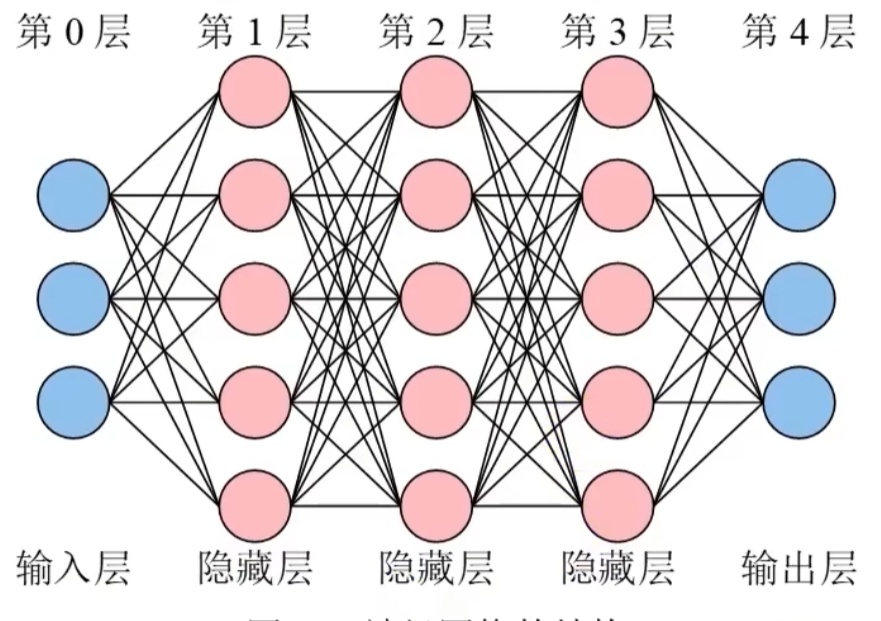

In [9]:
# 神经网络示意图
from IPython.display import Image

Image(filename='./images/4层神经网络全连接.png')

In [10]:
class Net(nn.Module):
    def __init__(self):
        """初始化神经网络"""
        # 下方将神经元扩充到了 25 个，5 个效果不好
        super(Net, self).__init__()
        self.net = nn.Sequential(  # 使用 Sequential 容器来按顺序组织网络层
            nn.Linear(3, 25), nn.ReLU(),  # 第 0 - 1 层：输入层 - 隐藏层
            nn.Linear(25, 25), nn.ReLU(),  # 第 1 - 2 层：隐藏层 - 隐藏层
            nn.Linear(25, 25), nn.ReLU(),  # 第 2 - 3 层：隐藏层 - 隐藏层
            nn.Linear(25, 3)   # 第 4 层：输出层
        )
        # Linear 是线性连接层 ，也叫做全连接层 （Fully Connected Layer）或稠密层 （Dense Layer，在 Keras/TensorFlow 中常用这个名称）
        # Linear 还有一个参数是 bias ，这个参数是 Wx + b 中的 b 要不要添加的意思。
        # ReLU 函数 （全称：Rectified Linear Unit ，修正线性单元。 ReLU(x) = max(0,x)
        # ReLU 函数还有一个参数是 inplace ，是要不要原地修改原来的对象，参考 pandas 的 df 中的 inplace
        # Linear(3,5) → ReLU → Linear(5,5) → ReLU → Linear(5,5) → ReLU → Linear(5,3)
        # 所有激活函数：https://docs.pytorch.org/docs/2.7/nn.html

    def forward(self, x):
        """向前传播"""
        return self.net(x)

In [11]:
# 创建神经网络
net = Net().to('cuda')
print(net)

Net(
  (net): Sequential(
    (0): Linear(in_features=3, out_features=25, bias=True)
    (1): ReLU()
    (2): Linear(in_features=25, out_features=25, bias=True)
    (3): ReLU()
    (4): Linear(in_features=25, out_features=25, bias=True)
    (5): ReLU()
    (6): Linear(in_features=25, out_features=3, bias=True)
  )
)


In [12]:
# 查看内部参数，在训练开始之前所有的可调参数都被赋予一个随机值，可以打印出来看看
for name, param in net.named_parameters():
    print(f"参数：{name}\n形状：{param.shape}\n数值：{param}\n")
# requires_grad=True 意思是都开启了梯度计算功能

参数：net.0.weight
形状：torch.Size([25, 3])
数值：Parameter containing:
tensor([[ 0.1475,  0.0896, -0.4041],
        [ 0.0231,  0.3475,  0.0215],
        [-0.4093, -0.4231,  0.4607],
        [-0.2362, -0.0397, -0.1475],
        [ 0.1713, -0.4260,  0.2950],
        [-0.2516,  0.4591,  0.5521],
        [ 0.4318, -0.3621,  0.2605],
        [ 0.5506, -0.0885,  0.5721],
        [-0.3181, -0.3356,  0.4070],
        [-0.0613,  0.5753,  0.3283],
        [-0.0922,  0.4839, -0.4229],
        [-0.2918, -0.5636,  0.1827],
        [-0.1347, -0.0020, -0.1887],
        [-0.4656, -0.2080, -0.3462],
        [-0.2637,  0.4541, -0.0035],
        [ 0.4954, -0.0636, -0.2830],
        [ 0.1507, -0.3677,  0.1770],
        [ 0.4242, -0.4076,  0.3190],
        [ 0.0514,  0.0039, -0.0331],
        [ 0.0545,  0.3930, -0.5530],
        [-0.4609, -0.3087,  0.4355],
        [ 0.3618, -0.1734, -0.2324],
        [ 0.2001, -0.0546,  0.2249],
        [-0.4457, -0.2501,  0.4938],
        [ 0.1193, -0.0532, -0.3005]], device='cu

In [13]:
# 损失函数就是判断目前输出结果和预期结果差距的函数，https://docs.pytorch.org/docs/2.7/nn.html 中搜索 Loss Function 可以找到所有损失函数
loss_fn = nn.MSELoss()
# 新参数 = 旧参数 − 学习率 × 梯度
learning_rate = 0.01  # 设置学习率
# 选择优化器，优化器的作用就是去更新就参数 net.parameters() 给出了一个迭代器，用于取出神经网络中每个可调参数的值
# SGD 优化器下每次只会输入一个样本，但是实际上我下面的代码直接一次性输入所有的内容，属于是 BSG 批量梯度下降
optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate)

tensor([[0.1103, 0.4613, 0.2923, 1.0000, 0.0000, 0.0000],
        [0.9810, 0.8346, 0.0412, 0.0000, 0.0000, 1.0000],
        [0.2651, 0.0030, 0.5609, 1.0000, 0.0000, 0.0000],
        ...,
        [0.3204, 0.4581, 0.6850, 0.0000, 1.0000, 0.0000],
        [0.8499, 0.9799, 0.5561, 0.0000, 0.0000, 1.0000],
        [0.2854, 0.4727, 0.7383, 0.0000, 1.0000, 0.0000]], device='cuda:0')


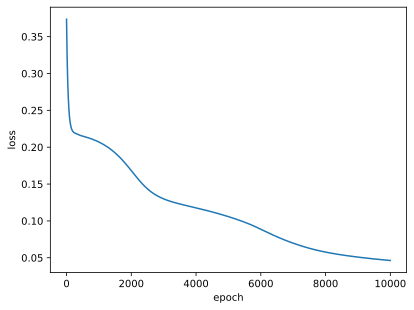

In [14]:
# 训练网络
epochs = 10000  # 总共训练轮数，测试下来 10000 轮训练效果较好，太多会过拟合导致测试集准确率下降
losses = []  # 记录每次训练的损失

# 划分训练集
X = train_data[:, :3]  # 输入内容
Y = train_data[:, 3:]  # 输出内容

print(train_data)

for _ in range(epochs):
    pred = net(X)                        # 前向传播，在向前传播的时候，把对象结果得到的计算方式保存在 grad_fn （用来计算梯度的函数）
    loss = loss_fn(pred, Y)              # 计算损失，由神经网络计算出来的内容与预期相比较，计算损失
    losses.append(loss.item())           # 记录损失
    optimizer.zero_grad()                # 清空梯度，pytorch 不会自己清空梯度，需要自己清空
    loss.backward()                      # 反向传播（计算梯度），梯度会保存到参数的 grad 对象中
    optimizer.step()                     # 更新参数

Fig = plt.figure()
plt.plot(range(epochs), losses)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

In [15]:
# 测试网络
X = test_data[:, :3]
Y = test_data[:, 3:]

print(test_data)

with torch.no_grad():
    pred = net(X)  # [6000, 3]
    # 获取预测类别
    pred_classes = torch.argmax(pred, dim=1)  # [6000], 每个值是 0,1,2
    correct_classes = torch.argmax(Y, dim=1)

    # Y 是 One-Hot 标签，如 [0,1,0]
    # 比较预测 One-Hot 和真实 One-Hot
    correct = torch.sum((pred_classes == correct_classes).sum())
    accuracy = 100 * correct / Y.size(0)
    print(f"准确率: {accuracy:.2f} %")

tensor([[0.2135, 0.0899, 0.1461, 1.0000, 0.0000, 0.0000],
        [0.2417, 0.2584, 0.3760, 1.0000, 0.0000, 0.0000],
        [0.9838, 0.2894, 0.4205, 0.0000, 1.0000, 0.0000],
        ...,
        [0.9116, 0.0554, 0.0563, 1.0000, 0.0000, 0.0000],
        [0.1947, 0.5098, 0.2841, 1.0000, 0.0000, 0.0000],
        [0.4470, 0.4960, 0.0991, 1.0000, 0.0000, 0.0000]], device='cuda:0')
准确率: 96.97 %


In [16]:
# 手动输入测试网络
"""
Y1 = ((X1 + X2 + X3) <= 1.3).float()
Y2 = ((1.3 < (X1 + X2 + X3)) & ((X1 + X2 + X3) < 1.75)).float()
Y3 = ((X1 + X2 + X3) >= 1.75).float()
"""
with torch.no_grad():
    # X1, X2, X3 = map(float, input("输入三个数据用空格隔开").split())
    X1, X2, X3 = (0.3958, 0.1472, 0.9097)
    if (X1 + X2 + X3) <= 1.3:
        print("此项理应为 0")
    elif 1.3 < (X1 + X2 + X3) < 1.75:
        print("此项理应为 1")
    else:
        print("此项理应为 2")
    t = torch.tensor([[X1, X2, X3]], dtype=torch.float32).to('cuda')
    pred = net(t)
    target = torch.argmax(pred, dim=1)
    print("模型预测该项属于", target.item())  # 预期应该是 1

此项理应为 1
模型预测该项属于 1


In [17]:
# # 保存网络
# torch.save(net, './net.pth')
# # 读取网络
# net = torch.load('./net.pth')